In [2]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

正在读取日志数据...
发现 11 个监控指标: ['hp_metric', 'lr-Adam', 'train/aeloss_step', 'train/total_loss', 'train/logvar', 'train/kl_loss', 'train/nll_loss', 'train/rec_loss', 'epoch', 'val/rec_loss', 'train/aeloss_epoch']


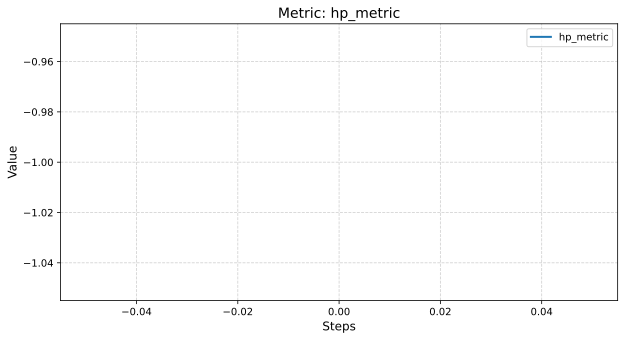

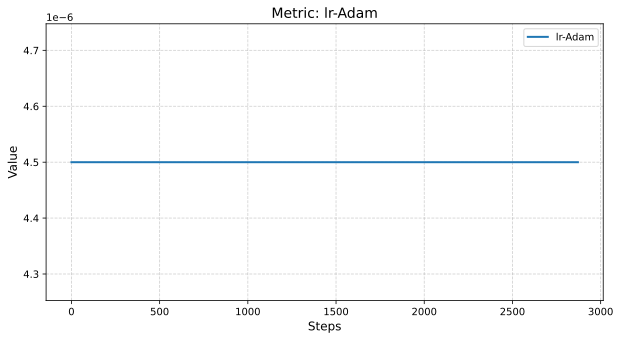

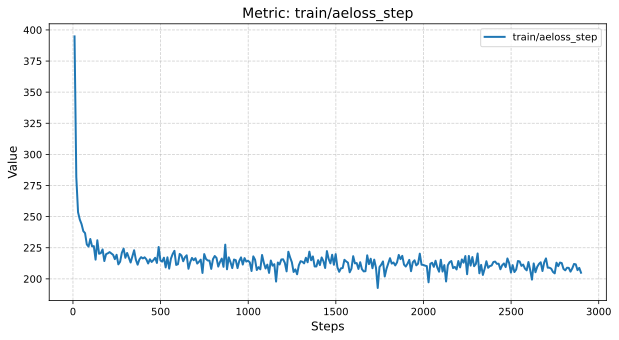

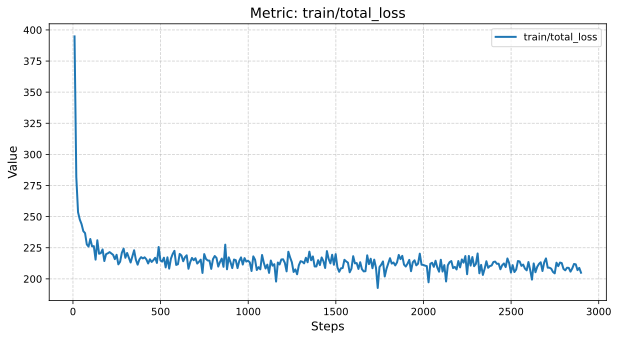

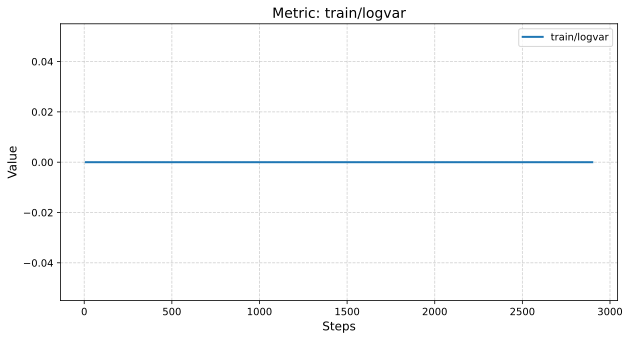

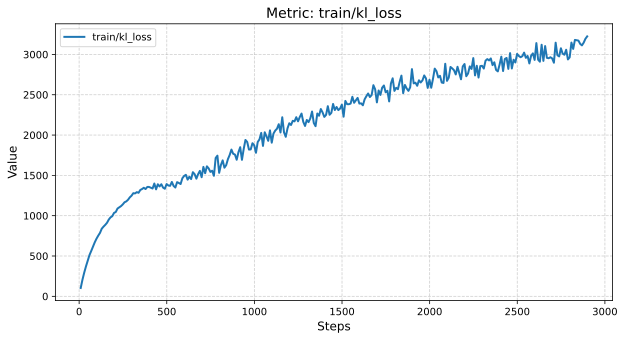

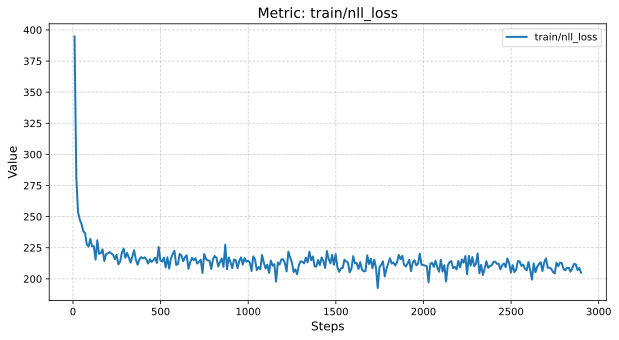

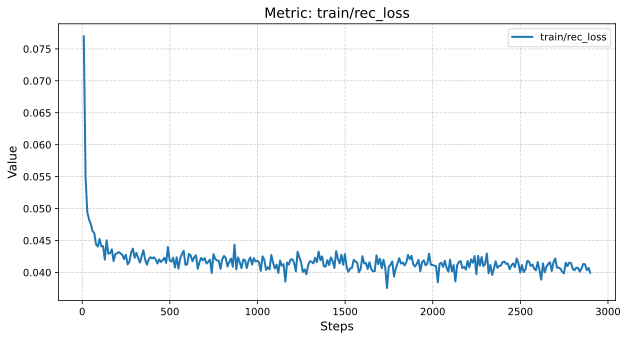

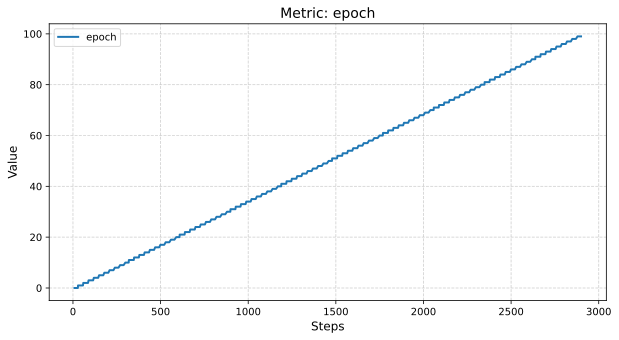

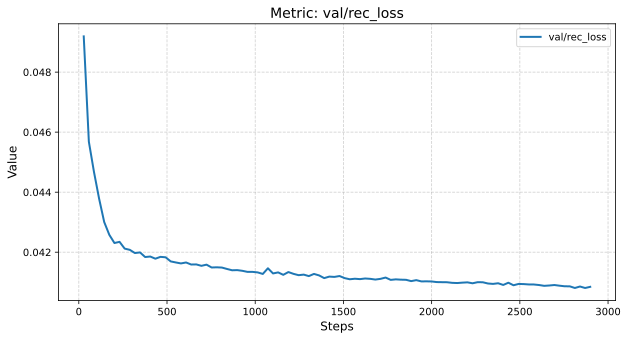

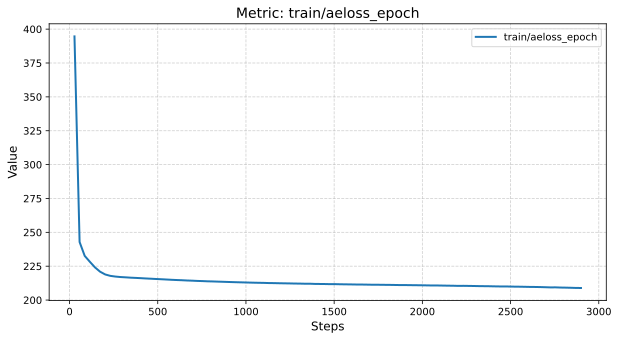

In [4]:
# 确保图片内嵌显示
%matplotlib inline

LOG_PATH = "components/resnet18_TinyImagenet_HC_VAE/lightning_logs/version_0/events.out.tfevents.1763935095.autodl-container-d8774488f4-b8482d06.6912.0"

def plot_tensorboard_log(path):
    # 1. 检查文件是否存在
    if not os.path.exists(path):
        print(f"❌ 错误：找不到文件，请检查路径是否正确：\n{path}")
        return

    print(f"正在读取日志数据...")
    
    # 2. 加载数据
    # size_guidance 用于加载更多数据点，避免被截断
    ea = EventAccumulator(path, size_guidance={ 'scalars': 0 })
    ea.Reload()

    # 3. 获取所有标量标签 (Scalars)
    tags = ea.Tags()['scalars']
    print(f"发现 {len(tags)} 个监控指标: {tags}")

    if len(tags) == 0:
        print("日志中没有发现标量数据 (Scalars)。")
        return

    # 4. 循环绘图
    for tag in tags:
        # 提取数据
        events = ea.Scalars(tag)
        steps = [x.step for x in events]
        values = [x.value for x in events]

        # 绘图
        plt.figure(figsize=(10, 5))
        plt.plot(steps, values, label=tag, linewidth=2)
        
        # 格式化图表
        plt.title(f"Metric: {tag}", fontsize=14)
        plt.xlabel("Steps", fontsize=12)
        plt.ylabel("Value", fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend()
        
        # 直接显示
        plt.show()

# --- 运行函数 ---
plot_tensorboard_log(LOG_PATH)

## Results: D2NWG vs GD and Sampling-Step Ablation

This section reads the CSVs produced by:
- `experiments/eval_generalization.py`
- `experiments/ablation_sampling_steps.py`

and plots:
1) Generalization comparison (D2NWG vs GD)
2) Ablation: DDIM steps vs validation loss/accuracy


In [6]:
from __future__ import annotations

from pathlib import Path
import csv

import numpy as np
import matplotlib.pyplot as plt


def _read_csv(path: str | Path, *, allow_missing: bool = False):
    path = Path(path)
    if not path.exists():
        if allow_missing:
            return []
        raise FileNotFoundError(f"CSV not found: {path}")
    with path.open("r", newline="") as f:
        return list(csv.DictReader(f))


def _to_float(x):
    try:
        return float(x)
    except Exception:
        return float("nan")


def _group_by(rows, key):
    out = {}
    for r in rows:
        out.setdefault(r[key], []).append(r)
    return out


def _mean_std(vals):
    vals = np.array([v for v in vals if np.isfinite(v)], dtype=float)
    if vals.size == 0:
        return float("nan"), float("nan")
    if vals.size == 1:
        return float(vals.mean()), 0.0
    return float(vals.mean()), float(vals.std(ddof=1))


def _existing_items(name_to_path: dict[str, str | Path]):
    for name, path in name_to_path.items():
        path = Path(path)
        if path.exists():
            yield name, path
        else:
            print(f"WARN: missing CSV for {name}: {path}")


RESULTS_DIR = Path("./results")

# Episodic few-shot comparison (D2NWG vs GD)
GENERALIZATION_CSVS = {
    "cifar10": RESULTS_DIR / "generalization_cifar10.csv",
    "stl10": RESULTS_DIR / "generalization_stl10.csv",
    "cifar100": RESULTS_DIR / "generalization_cifar100.csv",
    "tinyimagenet": RESULTS_DIR / "generalization_tinyimagenet.csv",
}

# DDIM steps ablation (D2NWG)
ABLATION_CSVS = {
    "cifar10": RESULTS_DIR / "ablation_steps_cifar10.csv",
    "stl10": RESULTS_DIR / "ablation_steps_stl10.csv",
    "tinyimagenet": RESULTS_DIR / "ablation_steps_tinyimagenet.csv",
}

# Full supervised baseline (train head on full train split)
SUPERVISED_GD_CSVS = {
    "cifar10": RESULTS_DIR / "supervised_gd_cifar10.csv",
    "stl10": RESULTS_DIR / "supervised_gd_stl10.csv",
    "cifar100": RESULTS_DIR / "supervised_gd_cifar100.csv",
    "tinyimagenet": RESULTS_DIR / "supervised_gd_tinyimagenet.csv",
}

print("Configured CSV paths:")
for k, v in GENERALIZATION_CSVS.items():
    print(" generalization", k, "->", v)
for k, v in ABLATION_CSVS.items():
    print(" ablation", k, "->", v)
for k, v in SUPERVISED_GD_CSVS.items():
    print(" supervised", k, "->", v)


Configured CSV paths:
 generalization cifar10 -> results/generalization_cifar10.csv
 generalization stl10 -> results/generalization_stl10.csv
 generalization cifar100 -> results/generalization_cifar100.csv
 generalization tinyimagenet -> results/generalization_tinyimagenet.csv
 ablation cifar10 -> results/ablation_steps_cifar10.csv
 ablation stl10 -> results/ablation_steps_stl10.csv
 ablation tinyimagenet -> results/ablation_steps_tinyimagenet.csv
 supervised cifar10 -> results/supervised_gd_cifar10.csv
 supervised stl10 -> results/supervised_gd_stl10.csv
 supervised cifar100 -> results/supervised_gd_cifar100.csv
 supervised tinyimagenet -> results/supervised_gd_tinyimagenet.csv


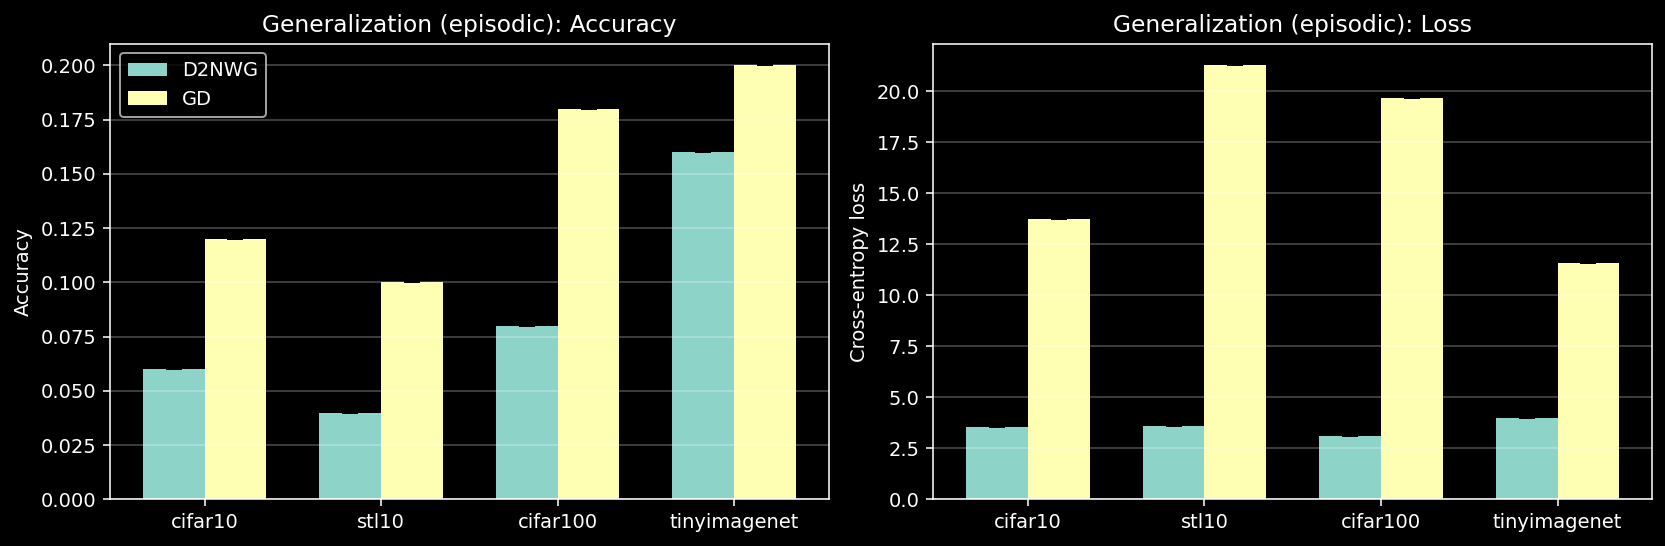

WARN: missing CSV for stl10: results/supervised_gd_stl10.csv
WARN: missing CSV for cifar100: results/supervised_gd_cifar100.csv
WARN: missing CSV for tinyimagenet: results/supervised_gd_tinyimagenet.csv


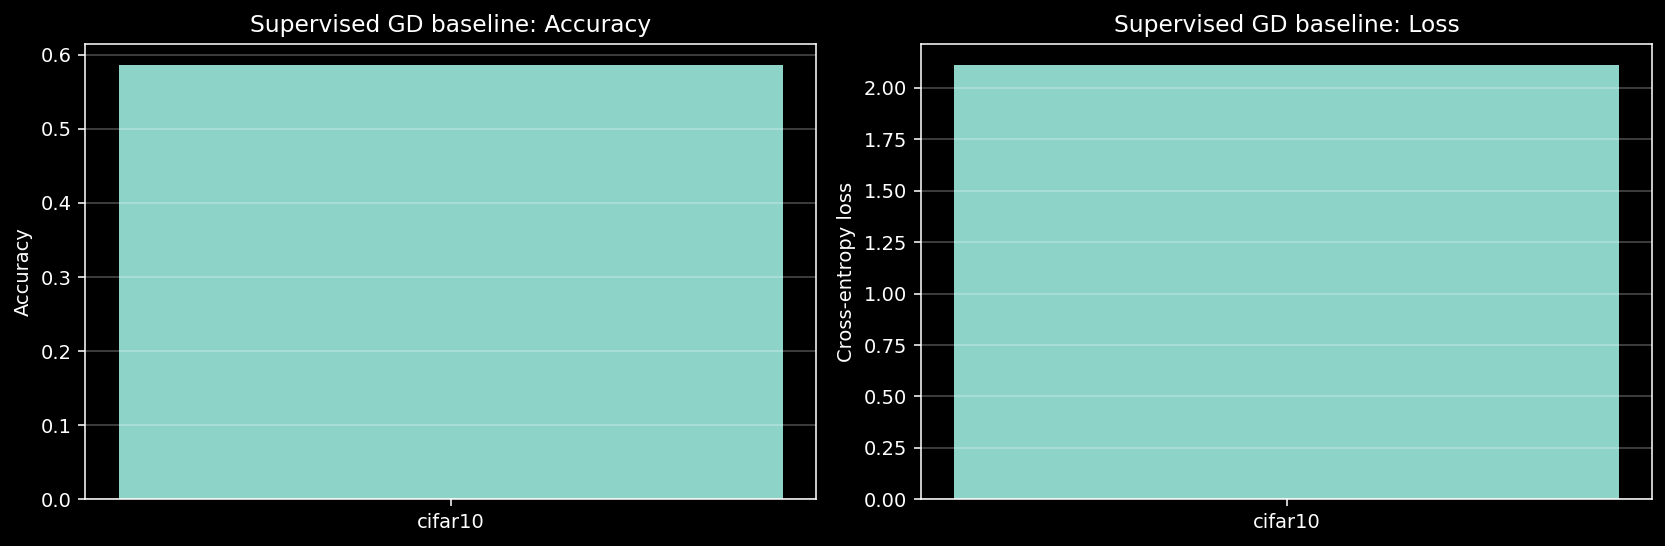

In [9]:
def plot_generalization_bar(generalization_csvs=GENERALIZATION_CSVS):
    datasets = []
    d2_acc = []
    d2_acc_std = []
    gd_acc = []
    gd_acc_std = []

    d2_loss = []
    d2_loss_std = []
    gd_loss = []
    gd_loss_std = []

    for ds_name, csv_path in _existing_items(generalization_csvs):
        rows = _read_csv(csv_path, allow_missing=True)
        if not rows:
            continue
        by_method = _group_by(rows, "method")

        d2_rows = by_method.get("d2nwg", [])
        gd_rows = by_method.get("gd", [])

        datasets.append(ds_name)

        d2_acc_m, d2_acc_s = _mean_std([_to_float(r.get("acc")) for r in d2_rows])
        gd_acc_m, gd_acc_s = _mean_std([_to_float(r.get("acc")) for r in gd_rows])
        d2_loss_m, d2_loss_s = _mean_std([_to_float(r.get("loss")) for r in d2_rows])
        gd_loss_m, gd_loss_s = _mean_std([_to_float(r.get("loss")) for r in gd_rows])

        d2_acc.append(d2_acc_m)
        d2_acc_std.append(d2_acc_s)
        gd_acc.append(gd_acc_m)
        gd_acc_std.append(gd_acc_s)

        d2_loss.append(d2_loss_m)
        d2_loss_std.append(d2_loss_s)
        gd_loss.append(gd_loss_m)
        gd_loss_std.append(gd_loss_s)

    if not datasets:
        print("WARN: no generalization CSVs found.")
        return None

    x = np.arange(len(datasets))
    width = 0.35

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=140)

    # Accuracy
    ax = axes[0]
    ax.bar(x - width / 2, d2_acc, width, yerr=d2_acc_std, capsize=4, label="D2NWG")
    ax.bar(x + width / 2, gd_acc, width, yerr=gd_acc_std, capsize=4, label="GD")
    ax.set_xticks(x)
    ax.set_xticklabels(datasets)
    ax.set_ylabel("Accuracy")
    ax.set_title("Generalization (episodic): Accuracy")
    ax.grid(True, axis="y", alpha=0.3)
    ax.legend()

    # Loss
    ax = axes[1]
    ax.bar(x - width / 2, d2_loss, width, yerr=d2_loss_std, capsize=4, label="D2NWG")
    ax.bar(x + width / 2, gd_loss, width, yerr=gd_loss_std, capsize=4, label="GD")
    ax.set_xticks(x)
    ax.set_xticklabels(datasets)
    ax.set_ylabel("Cross-entropy loss")
    ax.set_title("Generalization (episodic): Loss")
    ax.grid(True, axis="y", alpha=0.3)

    fig.tight_layout()
    return fig


def plot_supervised_gd_bar(supervised_csvs=SUPERVISED_GD_CSVS):
    datasets = []
    acc = []
    loss = []

    for ds_name, csv_path in _existing_items(supervised_csvs):
        rows = _read_csv(csv_path, allow_missing=True)
        if not rows:
            continue
        r = rows[0]
        datasets.append(ds_name)
        acc.append(_to_float(r.get("acc")))
        loss.append(_to_float(r.get("loss")))

    if not datasets:
        print("WARN: no supervised baseline CSVs found.")
        return None

    x = np.arange(len(datasets))

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=140)

    ax = axes[0]
    ax.bar(x, acc)
    ax.set_xticks(x)
    ax.set_xticklabels(datasets)
    ax.set_ylabel("Accuracy")
    ax.set_title("Supervised GD baseline: Accuracy")
    ax.grid(True, axis="y", alpha=0.3)

    ax = axes[1]
    ax.bar(x, loss)
    ax.set_xticks(x)
    ax.set_xticklabels(datasets)
    ax.set_ylabel("Cross-entropy loss")
    ax.set_title("Supervised GD baseline: Loss")
    ax.grid(True, axis="y", alpha=0.3)

    fig.tight_layout()
    return fig


# Display figures exactly once (avoid duplicate rendering from implicit inline display).
from IPython.display import display

fig = plot_generalization_bar()
if fig is not None:
    display(fig)
    plt.close(fig)

fig_sup = plot_supervised_gd_bar()
if fig_sup is not None:
    display(fig_sup)
    plt.close(fig_sup)


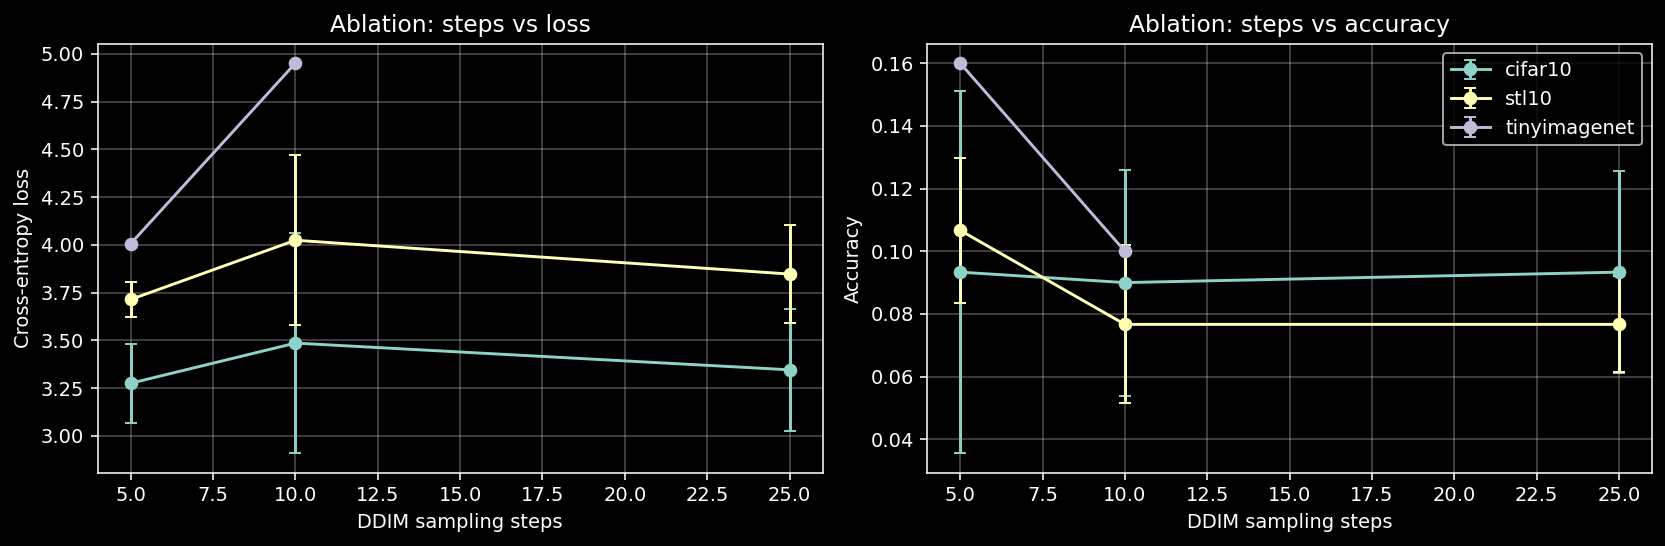

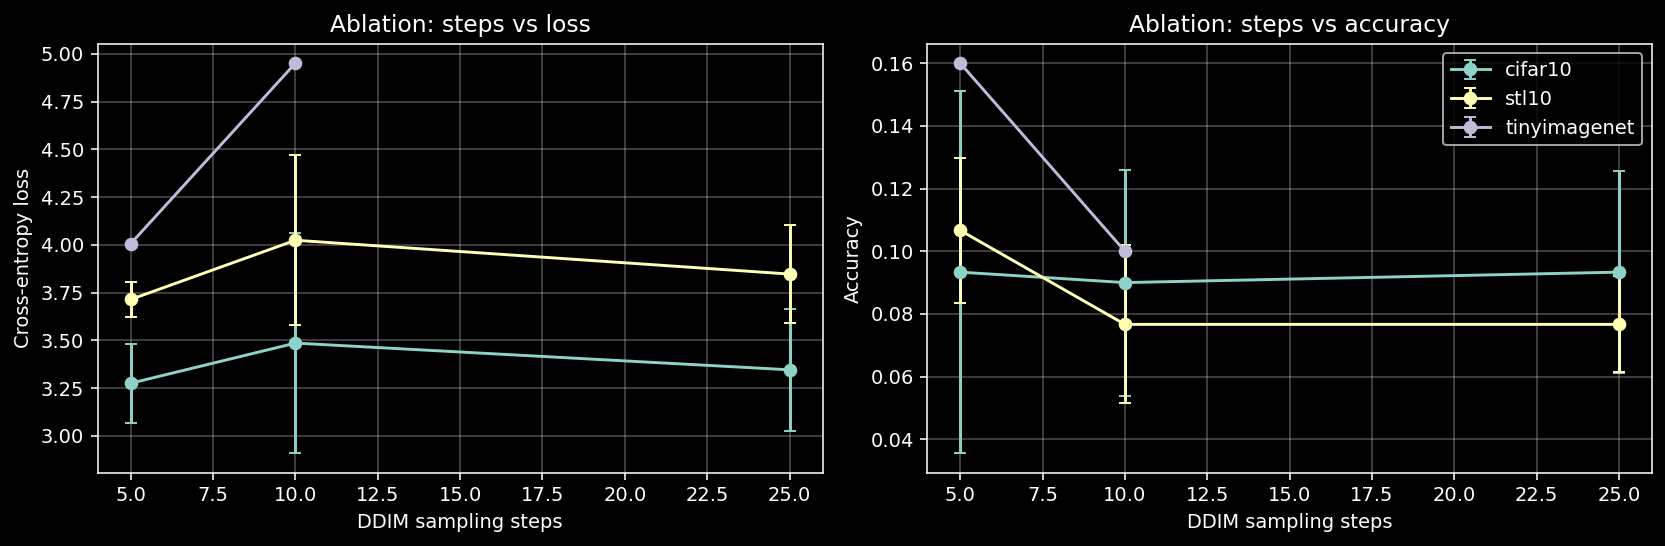

In [8]:
def plot_ablation_curves(ablation_csvs=ABLATION_CSVS):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=140)

    plotted_any = False
    for ds_name, csv_path in _existing_items(ablation_csvs):
        rows = _read_csv(csv_path, allow_missing=True)
        if not rows:
            continue
        plotted_any = True

        # group by steps
        by_steps = _group_by(rows, "steps")
        steps = sorted([int(s) for s in by_steps.keys()])

        step_loss_mean = []
        step_loss_std = []
        step_acc_mean = []
        step_acc_std = []

        for s in steps:
            rs = by_steps[str(s)]
            loss_m, loss_s = _mean_std([_to_float(r.get("loss")) for r in rs])
            acc_m, acc_s = _mean_std([_to_float(r.get("acc")) for r in rs])
            step_loss_mean.append(loss_m)
            step_loss_std.append(loss_s)
            step_acc_mean.append(acc_m)
            step_acc_std.append(acc_s)

        axes[0].errorbar(
            steps,
            step_loss_mean,
            yerr=step_loss_std,
            capsize=3,
            marker="o",
            label=ds_name,
        )
        axes[1].errorbar(
            steps,
            step_acc_mean,
            yerr=step_acc_std,
            capsize=3,
            marker="o",
            label=ds_name,
        )

    if not plotted_any:
        print("WARN: no ablation CSVs found.")
        return None

    axes[0].set_xlabel("DDIM sampling steps")
    axes[0].set_ylabel("Cross-entropy loss")
    axes[0].set_title("Ablation: steps vs loss")
    axes[0].grid(True, alpha=0.3)

    axes[1].set_xlabel("DDIM sampling steps")
    axes[1].set_ylabel("Accuracy")
    axes[1].set_title("Ablation: steps vs accuracy")
    axes[1].grid(True, alpha=0.3)

    axes[1].legend()
    fig.tight_layout()
    return fig


fig2 = plot_ablation_curves()
fig2
